In [1]:
# Importando os módulos que serão utilizados

import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import time
import dill

# Configurando o acesso do tensorflow aos processadores do computador
# no caso, está sendo selecionada a primeira placa de vídeo listada

gpus = tf.config.experimental.list_physical_devices('GPU') # Listando as placas de vídeo
tf.config.experimental.set_memory_growth(gpus[0], True)    # Selecionando a primeira GPU e configurando

# Importando os módulos contendo as funções criadas no projeto

from aux_func_V3 import *
import API_Numpy
import API_TensorFlow

In [2]:
Λ=1
Δx=0.1
Δt=Δx*0.5/Λ
Δt=2
WENO_Z_ref=lambda u0, Δx:Sim(u0,Δt, Δx, 0.5, FronteiraFixa)
Sim, Sim_step, DerivadaEspacial, Get_weights=create_simulation(API_Numpy,burgers_equation,WENO_Z)

WENO_JS_ref=lambda u0, Δx:Sim_JS(u0,Δt, Δx, 0.5, FronteiraFixa)
Sim_JS, Sim_step_JS, DerivadaEspacial_JS, Get_weights_JS=create_simulation(API_Numpy,burgers_equation,WENO_JS)

In [3]:
Total_time=1
granul_ref=4
np.random.seed(seed=13031998)
n=int(5000/2)
k=11
pesos=np.random.uniform(size=[n,k],low=-1,high=1)
ordem=np.floor(np.random.uniform(size=[n,1],low=1,high=k))+np.asarray([range(k)])
pesos=(1-np.sum(tf.one_hot(ordem,k),axis=1))*pesos

operador_derivada=np.eye(k,k=-1)@np.diag(range(1,k+1))

In [4]:
Δx_ref=Δx/granul_ref
x_ref=np.expand_dims(np.arange(-1,1,Δx_ref),axis=0)**np.expand_dims(np.arange(k),axis=1)

In [5]:
k1 = np.random.uniform(0, 10, [n,1]).astype('int32')   # Amostrando uma frequência aleatória para a função seno
k2 = np.random.uniform(0, 10, [n,1]).astype('int32')   # Amostrando uma frequência aleatória para a função seno
a  = np.random.uniform(0, 1, [n,1]) # Amostrando um peso aleatória para ponderar as funções seno
b  = np.random.uniform(0, 2, [n,1]) # Amostrando um modificador de amplitude aleatório
u1 =     a * tf.math.sin(k1*pi*x_ref[1]) # Gerando pontos de acordo com a primeira função seno
u2 = (1-a) * tf.math.sin(k2*pi*x_ref[1]) # Gerando pontos de acordo com a segunda função seno

y_sin=(b*(u1+u2))

y=np.matmul(pesos,x_ref)
y=np.concatenate([y,y_sin],axis=0)

y_max=np.max(np.abs(y))
y =Λ*y/y_max

n=2*n

In [6]:
for l in range(7):
    polis=np.floor(np.random.uniform(size=[n,2],low=0,high=y.shape[0]))
    y0=y[polis[:,0].astype('int32')]
    y1=y[polis[:,1].astype('int32')]
    position=np.floor(np.random.uniform(size=[n],low=0,high=y.shape[1])).astype('int32')
    
    for i,j in zip(range(n),position):
        y0[i,j:]=0
        y1[i,:j]=0
    y=y0+y1

In [7]:
y_list=[]
dy_list=[]
dy=y[...]
for i in range(Total_time):
    print(i,end='\r')
    y=dy[...]
    dy=WENO_Z_ref(y[...],Δx_ref)
    
    y_list.append(y)
    dy_list.append(dy)
    
dy=np.concatenate(dy_list,axis=0)[:,np.arange(0,y[1].shape[0],granul_ref)]
y =np.concatenate( y_list,axis=0)[:,np.arange(0,y[1].shape[0],granul_ref)]

In [8]:
y.shape

(5000, 20)

In [9]:
erro_js=np.mean(np.abs(WENO_JS_ref(y,Δx)-dy))
erro_z=np.mean(np.abs(WENO_Z_ref(y,Δx)-dy))

print(erro_js/erro_z)

1.0161900980651808


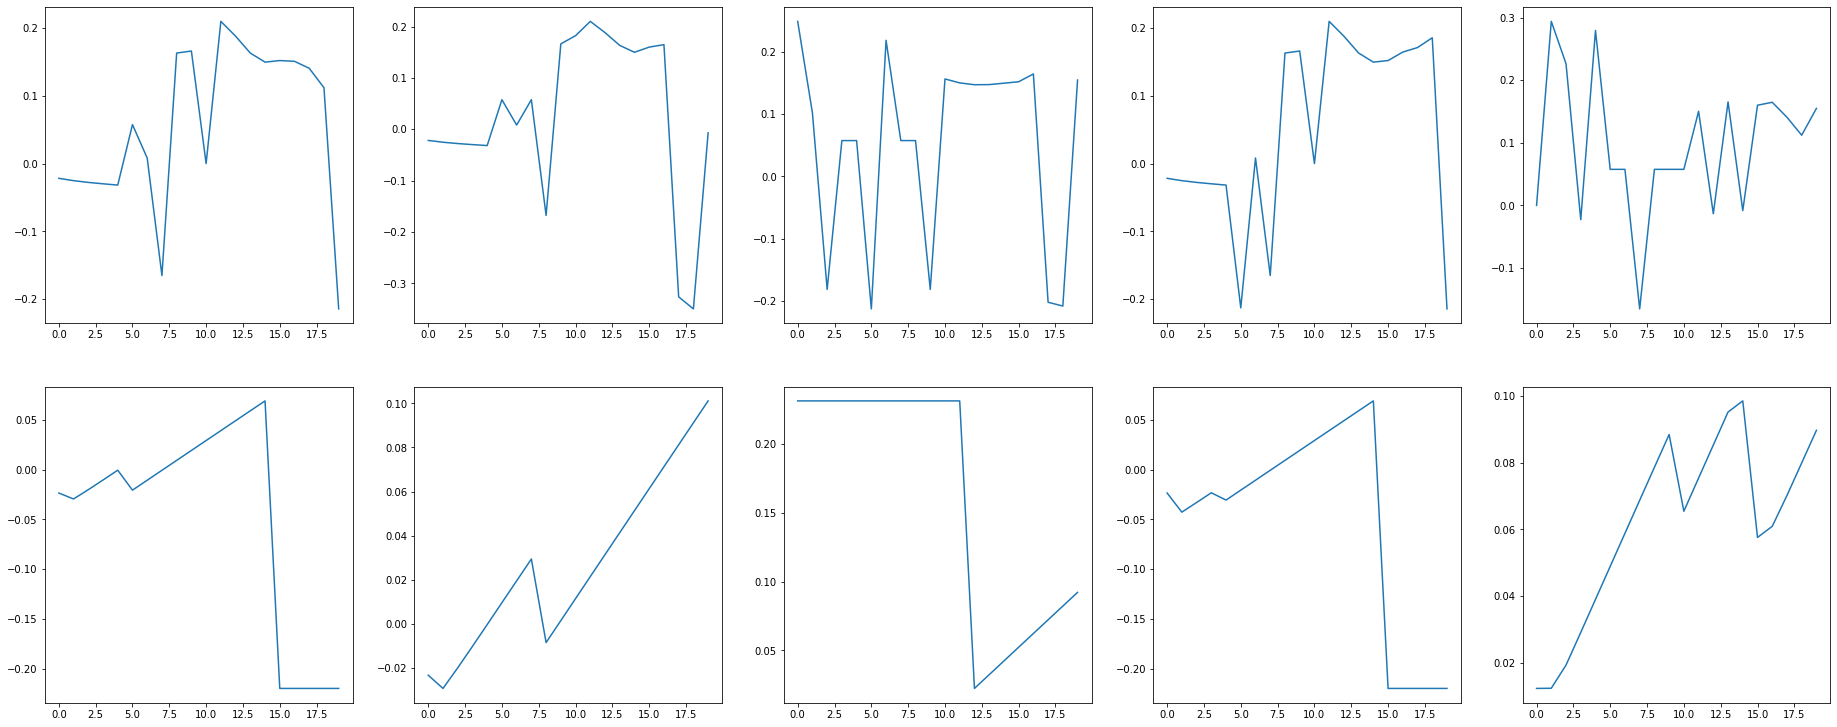

In [ ]:
index=np.floor(np.random.uniform(size=[5],low=0,high=n*Total_time)).astype('int32')

plt.figure(figsize=(6.4*5,6.4*2))
for i,j in zip(range(5),index):
    plt.subplot(2, 5, i+1)
    plt.plot(y[j])
    plt.subplot(2, 5, i+6)
    plt.plot(dy[j])

In [10]:
with open('datasets\\Dados temporais 2 - dx=0.1 dt=10.bkp','wb') as file:
    dill.dump([y,dy],file)